Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from metadPy.hierarchical import hmetad
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
import arviz as az
from plotting import raincloud

sns.set_context('notebook')

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


This notebook analyses the confidence ratings and generates the metacognition figures. Metacognitive sensitivity is estimated using the [H-Meta-d](https://github.com/metacoglab/HMeta-d) toolbox from the R interface. This requires that JAGS is installed on your system. 

The script `run_individualLevel.R` will fit a model and estimate `meta-d'` for each subject, session and modalities separately. The results are used in the correlation matrices (see `5-Correlations.ipynb`). 

The script `run_repeatedMeasures.R` will fit a repeated measures model for each session separately. It estimates the M-ratio for each participant and the beta values of the modalities effect. The results are presented in the metacognition figures.

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Discretize ratings and merge data frame

Filter trial level dataframe, discretize confidence rating and store results in `metacognition_trials.txt` for the two sessions.

In [3]:
metacognition_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    drop = []
    merged_df = pd.read_csv(path + f'/data/{session}_merged.txt')
    for sub in merged_df.Subject.unique():
        for cond in ['Extero', 'Intero']:
            this_df = merged_df[(merged_df.Subject==sub) & (merged_df.Modality==cond)]

            # Drop NAs
            this_df = this_df[~this_df.Confidence.isnull()]
            
            # Remove HR outliers
            this_df = this_df[this_df.HeartRateOutlier==0]
            
            # Discretize ratings
            try:
                this_df.loc[:, 'ConfidenceRaw'] = this_df.Confidence.to_numpy()
                new_ratings, out = discreteRatings(this_df.Confidence.to_numpy(), verbose=False)
                this_df.loc[:, 'Confidence'] = new_ratings
                this_df['Session'] = session
                this_df['Stimuli'] = this_df['Alpha'] > 0
                this_df['Responses'] = this_df['Decision'] == 'More'
                this_df['Accuracy'] = (this_df['Stimuli'] & this_df['Responses']) | (~this_df['Stimuli'] & ~this_df['Responses'])
                this_df = this_df[['Subject', 'Session', 'Modality', 'Stimuli', 'Accuracy', 'Responses', 'Confidence', 'ConfidenceRaw']]
                metacognition_df = metacognition_df.append(this_df)
                
                if (this_df['Stimuli'].sum() == 0):
                    drop.append(sub)

            except ValueError:
                print(f'Dropping subject {sub} due to invalid ratings - Session: {session}')
                drop.append(sub)
                
    for sub in drop:
        metacognition_df = metacognition_df[metacognition_df.Subject!=sub]

metacognition_df.to_csv(path + '/data/metacognition_trials.txt')

Dropping subject sub_0245 due to invalid ratings - Session: Del1
Dropping subject sub_0084 due to invalid ratings - Session: Del2


In [4]:
print(f"n Subjects session 1 = {metacognition_df[metacognition_df.Session=='Del1'].Subject.nunique()} - n Subjects session 1 = {metacognition_df[metacognition_df.Session=='Del2'].Subject.nunique()}")

n Subjects session 1 = 204 - n Subjects session 1 = 190


Extract d prime and criterion in `sdt_df` and save response ratings in `responsesRatings_df`. This second data frame is used by the R scripts to fit the hierarchicals models.

In [5]:
sdt_df = pd.DataFrame([])
responsesRatings_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    for sub in metacognition_df[metacognition_df.Session==session].Subject.unique():
        for cond in metacognition_df.Modality.unique():
            this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Session==session) & (metacognition_df.Modality==cond)]
                    
            nR_S1, nR_S2 = trials2counts(
                data=this_df, stimuli='Stimuli', accuracy='Accuracy',
                confidence='Confidence', nRatings=4)

            responsesRatings_df = responsesRatings_df.append(pd.DataFrame({
                'Subject': sub, 'Modality': cond, 'Session': session, 'nR_S1': nR_S1, 'nR_S2': nR_S2}))

            sdt_df = sdt_df.append(pd.DataFrame({
                'Subject': [sub],
                'Session': session,
                'Modality': [cond],
                'RespCountS1': nR_S1.sum(),
                'RespCountS2': nR_S2.sum(),
                'Accuracy': this_df.Accuracy.to_numpy().mean() * 100,
                'ConfidenceRaw': this_df.ConfidenceRaw.to_numpy().mean(),
                'd': [this_df.dprime()],
                'c': [this_df.criterion()]}))

for sub in drop:
    responsesRatings_df = responsesRatings_df[responsesRatings_df.Subject!=sub]
    sdt_df = sdt_df[sdt_df.Subject!=sub]

In [6]:
responsesRatings_df.to_csv(path + '/data/responsesRatings.txt', index=False)
sdt_df.to_csv(path + '/data/sdt.txt', index=False)

# d', criterion and confidence

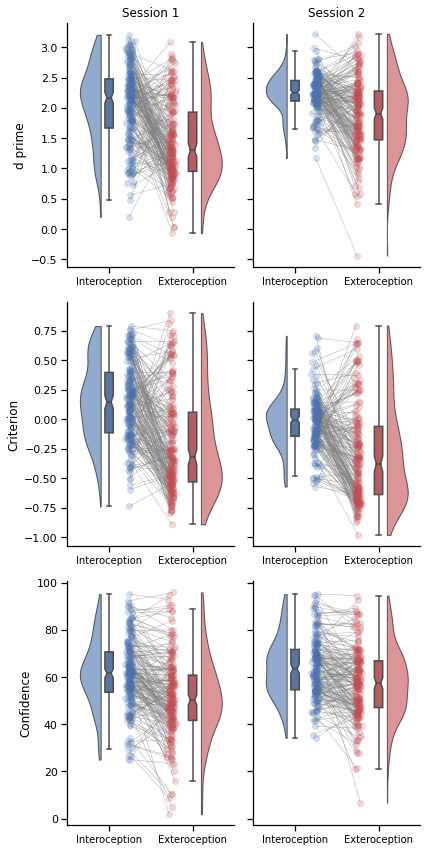

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(6, 12), sharey='row')
for i, metric in enumerate(['d', 'c', 'ConfidenceRaw']):
    for ii, session in enumerate(['Del1', 'Del2']):
        raincloud(data=sdt_df[(sdt_df.Session==session)], x='Modality', y=metric, ax=axs[i, ii], palette=['#4c72b0', '#c44e52'])
        labels = [item.get_text() for item in axs[i, ii].get_xticklabels()]
        labels[0] = 'Interoception'
        labels[1] = 'Exteroception'
        axs[i, ii].set_xticklabels(labels, size=10)

axs[0, 0].set_title('Session 1')
axs[0, 1].set_title('Session 2')
axs[0, 0].set_ylabel('d prime')
axs[1, 0].set_ylabel('Criterion')
axs[2, 0].set_ylabel('Confidence')

plt.tight_layout()
sns.despine()

## Session 1

### d prime

In [8]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Intero')].d.to_numpy(), func='mean')

array([1.34, 1.52])

In [9]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Extero')].d.to_numpy(), func='mean')

array([1.96, 2.13])

In [10]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del1'], dv='d', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,2.0521,0.624174,1.431045,0.651283,True,True,9.424544,203.0,two-sided,1.006012e-17,5.069e+14,0.973634


### Criterion

In [11]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Intero')].c.to_numpy(), func='mean')

array([-0.25, -0.14])

In [12]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Extero')].c.to_numpy(), func='mean')

array([0.11, 0.2 ])

In [13]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del1'], dv='c', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,0.153259,0.331668,-0.19621,0.424768,True,True,9.696867,203.0,two-sided,1.639443e-18,2.998e+15,0.91707


### Confidence

In [14]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Intero')].ConfidenceRaw.to_numpy(), func='mean')

array([49.24, 53.75])

In [15]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Extero')].ConfidenceRaw.to_numpy(), func='mean')

array([59.45, 63.31])

In [16]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del1'], dv='ConfidenceRaw', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,61.446992,14.350157,51.529449,17.039433,True,True,10.018194,203.0,two-sided,1.884218e-19,2.5e+16,0.629594


## Session 2

### d prime

In [17]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Intero')].d.to_numpy(), func='mean')

array([1.79, 1.96])

In [18]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Extero')].d.to_numpy(), func='mean')

array([2.21, 2.3 ])

In [19]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del2'], dv='d', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,2.25608,0.311399,1.880898,0.607207,True,True,8.101825,189.0,two-sided,6.559040e-14,9.672e+10,0.777531


### Criterion

In [20]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Intero')].c.to_numpy(), func='mean')

array([-0.35, -0.24])

In [21]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Extero')].c.to_numpy(), func='mean')

array([-0.05,  0.01])

In [22]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del2'], dv='c', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,-0.022044,0.222303,-0.301301,0.408229,True,True,9.115943,189.0,two-sided,1.146571e-16,4.759e+13,0.849613


### Confidence

In [23]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Intero')].ConfidenceRaw.to_numpy(), func='mean')

array([55.29, 59.46])

In [24]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Extero')].ConfidenceRaw.to_numpy(), func='mean')

array([62.56, 66.02])

In [25]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del2'], dv='ConfidenceRaw', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,64.2739,12.625144,57.471731,14.723497,True,True,7.157196,189.0,two-sided,1.769382e-11,4.184e+08,0.495983


# Session * Condition ANOVA

Remove participants if the two session were not completed.

In [26]:
for sub in sdt_df.Subject.unique():
    if sdt_df[sdt_df.Subject == sub].d.isnull().any():
        sdt_df = sdt_df[sdt_df.Subject!=sub]
    if len(sdt_df[sdt_df.Subject == sub].d)<4:
        sdt_df = sdt_df[sdt_df.Subject!=sub]

In [27]:
sdt_df.Subject.nunique()

177

## d prime

In [28]:
pg.rm_anova(data=sdt_df, subject='Subject', dv='d', within=['Session', 'Modality'])

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Session,18.253209,1,176,18.253209,59.823519,7.708444e-13,7.708444e-13,0.253679,1.0
1,Modality,40.854815,1,176,40.854815,114.813501,6.077808e-21,6.077808e-21,0.394801,1.0
2,Session * Modality,2.005827,1,176,2.005827,7.193492,8.013573e-03,8.013573e-03,0.039267,1.0


In [29]:
pg.pairwise_ttests(data=sdt_df, subject='Subject', dv='d', within=['Modality', 'Session'], effsize='cohen', return_desc=True)

,Contrast,Modality,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,-,Extero,Intero,2.148593,0.363547,1.668158,0.473691,True,True,10.715106,176.0,two-sided,6.077808e-21,7.449e+17,1.137863
1,Session,-,Del1,Del2,1.747810,0.444897,2.068941,0.365044,True,True,-7.734566,176.0,two-sided,7.708444e-13,8.95e+09,-0.789149
2,Modality * Session,Extero,Del1,Del2,2.041254,0.630503,2.255932,0.315565,True,True,-4.185851,176.0,two-sided,4.480673e-05,313.312,-0.430600
3,Modality * Session,Intero,Del1,Del2,1.454365,0.654303,1.881950,0.609777,True,True,-6.787863,176.0,two-sided,1.676260e-10,4.838e+07,-0.676096


## Confidence

In [30]:
pg.rm_anova(data=sdt_df, subject='Subject', dv='ConfidenceRaw', within=['Session', 'Modality'])

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Session,2881.162771,1,176,2881.162771,26.377744,7.393153e-07,7.393153e-07,0.130339,1.0
1,Modality,11889.509369,1,176,11889.509369,101.375889,4.055682e-19,4.055682e-19,0.365482,1.0
2,Session * Modality,437.446007,1,176,437.446007,8.725703,3.566657e-03,3.566657e-03,0.047236,1.0


In [31]:
pg.pairwise_ttests(data=sdt_df, subject='Subject', dv='ConfidenceRaw', within=['Modality', 'Session'], effsize='cohen', return_desc=True)

,Contrast,Modality,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,-,Extero,Intero,62.542551,11.972423,54.346676,14.157112,True,True,10.068559,176.0,two-sided,4.055682e-19,1.211e+16,0.625145
1,Session,-,Del1,Del2,56.427329,13.976426,60.461899,12.016450,True,True,-5.135927,176.0,two-sided,7.393153e-07,1.521e+04,-0.309558
2,Modality * Session,Extero,Del1,Del2,61.311308,14.558296,63.773795,12.547959,True,True,-2.547106,176.0,two-sided,1.171821e-02,1.931,-0.181194
3,Modality * Session,Intero,Del1,Del2,51.543349,16.283764,57.150003,14.571525,True,True,-6.024765,176.0,two-sided,9.658031e-09,9.687e+05,-0.362858


# Raw confidence ratings

The `rawConfidence_df` data frame is used to create the bar plots of the confidence ratings.

In [32]:
rawConfidence_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    for sub in metacognition_df[metacognition_df.Session==session].Subject.unique():
        for cond in metacognition_df.Modality.unique():
            for corr in [True, False]:
                this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Modality==cond) & (metacognition_df.Session==session) & (metacognition_df.Accuracy==corr)]
                new_ratings = this_df.Confidence.to_numpy()
                rawConfidence_df = rawConfidence_df.append(pd.DataFrame({
                    'Subject': sub,
                    'Session': session,
                    'Modality': cond,
                    'Correct': corr,
                    'Ratings': np.arange(1, 5),
                    'Density': np.array([np.count_nonzero(new_ratings == i) for i in range(1, 5)]) / len(new_ratings)}), ignore_index=True)

# Session 1

In [33]:
print(f'{rawConfidence_df[rawConfidence_df.Session=="Del1"].Subject.nunique()} remaining subjects in Session 1')

204 remaining subjects in Session 1


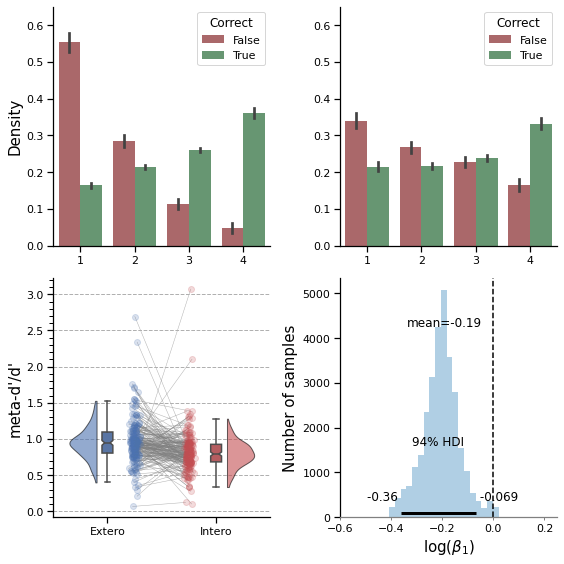

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i, cond in enumerate(['Extero', 'Intero']):
    sns.barplot(data=rawConfidence_df[(rawConfidence_df.Modality==cond) & (rawConfidence_df.Session=='Del1')], x='Ratings', y='Density', hue='Correct', ax=axs[0, i], palette=["#b55d60", "#5f9e6e"])
    labels = [item.get_text() for item in axs[0, i].get_xticklabels()]

axs[0, 0].set_ylabel('Density', size=15)
axs[0, 1].set_ylabel('')
axs[0, 0].set_xlabel('')
axs[0, 1].set_xlabel('')
axs[0, 0].set_ylim(0, 0.65)
axs[0, 1].set_ylim(0, 0.65)

samples = pd.read_csv(path + '/data/jagsSamples_Del1.txt', sep='\t')
stats = pd.read_csv(path + '/data/jagsStats_Del1.txt', sep='\t')
stats['Modality'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Modality'] = 'Extero'
stats = stats[stats.name.str.contains('Mratio')]
stats = stats.sort_values('Modality')

raincloud(data=stats, x='Modality', y='mean', show_outliers=False, ax=axs[1, 0])
axs[1, 0].set_ylabel("meta-d'/d'", size=15)
axs[1, 0].set_xlabel('')
axs[1, 0].minorticks_on()
axs[1, 0].set_axisbelow(True)
axs[1, 0].grid(which='major', linestyle='--', axis='y')
axs[1, 0].tick_params(axis='x', which='minor', bottom=False)

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1, 1])
axs[1, 1].axvline(x=0, linestyle='--', color='k')
axs[1, 1].set_xlim(-.6, .25)
axs[1, 1].set_ylabel('Number of samples', size=15)
axs[1, 1].set_xlabel(r'log($\beta_{1}$)', size=15)
axs[1, 1].set_title('')
axs[1, 1].set_yticks([0, 1000, 2000, 3000, 4000, 5000])

plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/Fig3_metacognition.svg', dpi=300)

In [35]:
print(pg.compute_bootci(stats[stats.Modality=='Intero']['mean'], func='mean'))
print(stats[stats.Modality=='Intero']['mean'].mean())

[0.78 0.86]
0.8176257595846838


In [36]:
print(pg.compute_bootci(stats[stats.Modality=='Extero']['mean'], func='mean'))
print(stats[stats.Modality=='Extero']['mean'].mean())

[0.93 1.01]
0.9665117226519826


# Session 2

In [37]:
print(f'{rawConfidence_df[rawConfidence_df.Session=="Del2"].Subject.nunique()} remaining subjects in Session 2')

190 remaining subjects in Session 2


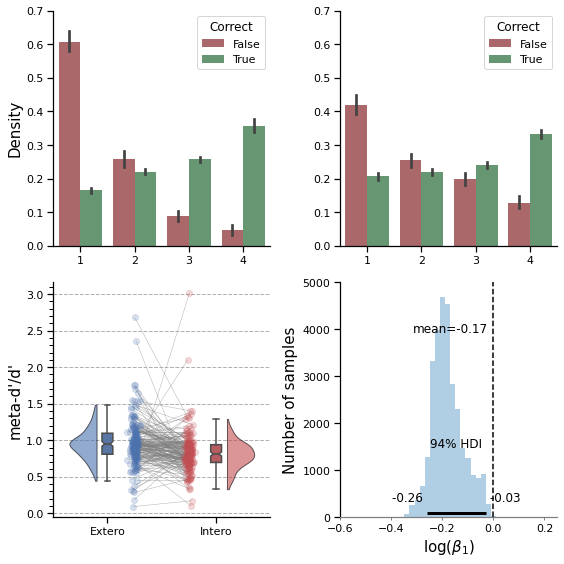

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i, cond in enumerate(['Extero', 'Intero']):
    sns.barplot(data=rawConfidence_df[(rawConfidence_df.Modality==cond) & (rawConfidence_df.Session=='Del2')], x='Ratings', y='Density', hue='Correct', ax=axs[0, i], palette=["#b55d60", "#5f9e6e"])
    labels = [item.get_text() for item in axs[0, i].get_xticklabels()]

axs[0, 0].set_ylabel('Density', size=15)
axs[0, 1].set_ylabel('')
axs[0, 0].set_xlabel('')
axs[0, 1].set_xlabel('')
axs[0, 0].set_ylim(0, 0.7)
axs[0, 1].set_ylim(0, 0.7)

samples = pd.read_csv(path + '/data/jagsSamples_Del2.txt', sep='\t')
stats = pd.read_csv(path + '/data/jagsStats_Del2.txt', sep='\t')
stats['Modality'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Modality'] = 'Extero'
stats = stats[stats.name.str.contains('Mratio')]
stats = stats.sort_values('Modality')

raincloud(data=stats, x='Modality', y='mean', show_outliers=False, ax=axs[1, 0])
axs[1, 0].set_ylabel("meta-d'/d'", size=15)
axs[1, 0].set_xlabel('')
axs[1, 0].minorticks_on()
axs[1, 0].set_axisbelow(True)
axs[1, 0].grid(which='major', linestyle='--', axis='y')
axs[1, 0].tick_params(axis='x', which='minor', bottom=False)

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1, 1])
axs[1, 1].axvline(x=0, linestyle='--', color='k')
axs[1, 1].set_xlim(-.6, .25)
axs[1, 1].set_ylabel('Number of samples', size=15)
axs[1, 1].set_xlabel(r'log($\beta_{1}$)', size=15)
axs[1, 1].set_title('')
axs[1, 1].set_yticks([0, 1000, 2000, 3000, 4000, 5000])

plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/SupplementaryMaterial3_metacognition.svg', dpi=300)

In [39]:
print(pg.compute_bootci(stats[stats.Modality=='Intero']['mean'], func='mean'))
print(stats[stats.Modality=='Intero']['mean'].mean())

[0.79 0.88]
0.8315124635102121


In [40]:
print(pg.compute_bootci(stats[stats.Modality=='Extero']['mean'], func='mean'))
print(stats[stats.Modality=='Extero']['mean'].mean())

[0.92 1.01]
0.9685709371040904
